**EE258 Neural Networks**
Project-2
Fall 2020


By:
1)Rojin Zandi
2)Shifa Shaikh

# 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Reading data from the directories

In [2]:
data=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv") #train

test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv") #test

sub = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv') #submission

In [3]:
#Checking GPU availability

import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


# 3. Data Description and Visualization

In [4]:
data.head() #Checking the first 5 rows in the train data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
data.describe() #analysis of numerical values in the train data

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
data.shape #train data dimension

(7613, 5)

In [7]:
test.shape #test data shape

(3263, 4)

In [8]:
test.head() #Checking the first 5 rows in the test data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


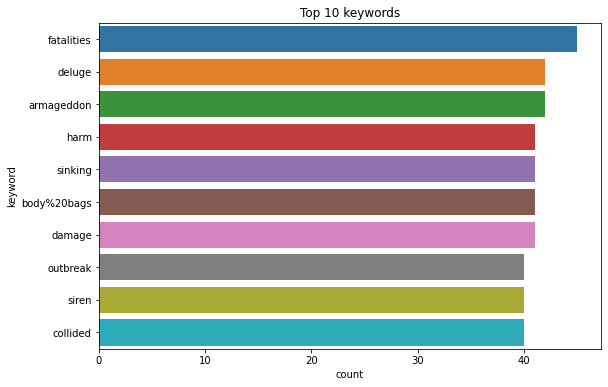

In [9]:
#Count-plot of train set 

plt.figure(figsize=(9,6))
sns.countplot(y=data.keyword, order = data.keyword.value_counts().iloc[:10].index)
plt.title('Top 10 keywords')
plt.show()

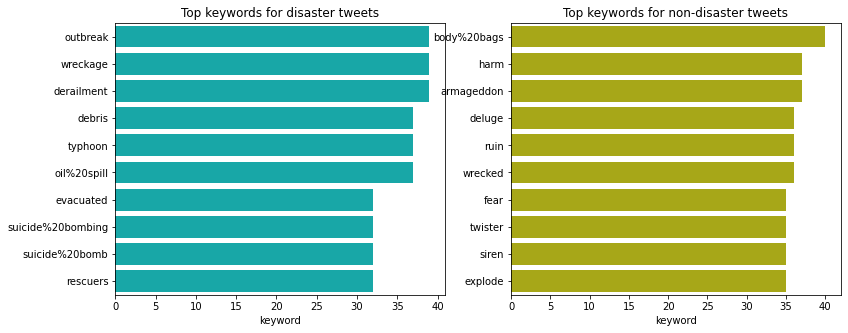

In [10]:
#Bar plot of disaster tweets and non-disaster tweets

kw_d = data[data.target==1].keyword.value_counts().head(10) #First 10 Disaster tweets 
kw_nd = data[data.target==0].keyword.value_counts().head(10) #First 10 Non-disaster tweets

plt.figure(figsize=(13,5))

#Plot-1 for disaster tweets
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='c')
plt.title('Top keywords for disaster tweets')

#Plot-2 for Non-disaster tweets
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

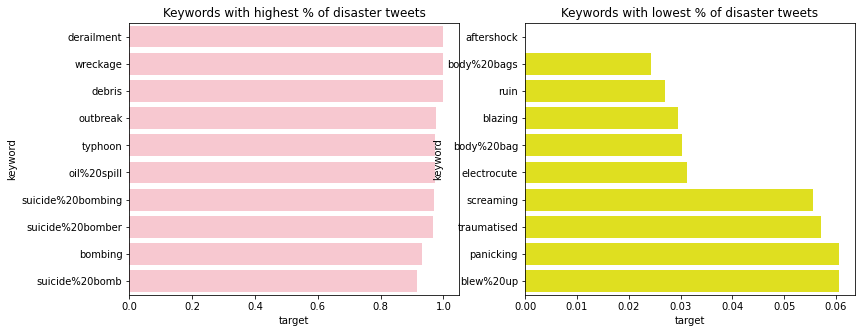

In [11]:

top_d = data.groupby('keyword').mean()['target'].sort_values(ascending=False).head(10)
top_nd = data.groupby('keyword').mean()['target'].sort_values().head(10)

plt.figure(figsize=(13,5))

plt.subplot(121)
sns.barplot(top_d, top_d.index, color='pink')
plt.title('Keywords with highest % of disaster tweets')

plt.subplot(122)
sns.barplot(top_nd, top_nd.index, color='yellow')
plt.title('Keywords with lowest % of disaster tweets')
plt.show()

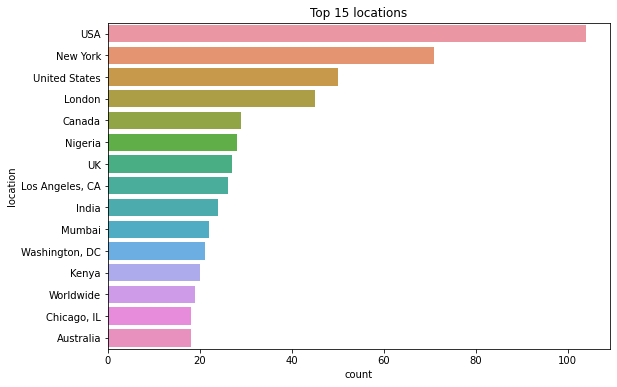

In [12]:
# Most common locations in the tweets

plt.figure(figsize=(9,6))
sns.countplot(y=data.location, order = data.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

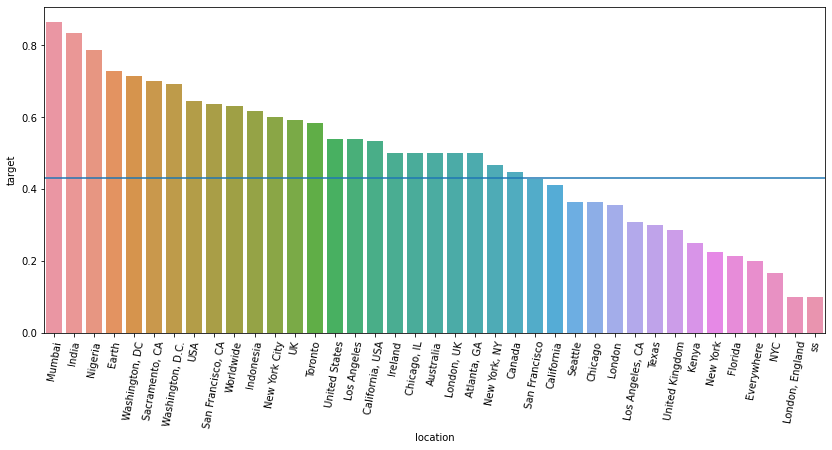

In [13]:
#locations plot

raw_loc = data.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = data[data.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(data.target))
plt.xticks(rotation=80)
plt.show()

# 4. Data Cleaning & Pre-processing

In [14]:
#data-cleaning

def clean_text(text):
    
    sw = stopwords.words('english') #Stopwords from NLTK.Corpus
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [15]:
#list of mispelled words

mispell_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

Reference - https://www.kaggle.com/mlwhiz/textcnn-pytorch-and-keras

In [16]:
#getting the misspell words
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)


#replacing the missepells
def replace_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

In [17]:
#applying the changes to the train data

data['text'] = data['text'].str.lower() #convert everything to lower-case words

data['text'] = data['text'].apply(lambda x: replace_misspell(x)) #replace the misspell words

data['text'] = data['text'].apply(lambda x: clean_text(x)) #clean the data using the above function



data.head(3) #check the changes

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1


In [18]:
#repeat the same process for the test data too

test['text'] = test['text'].str.lower()

test['text'] = test['text'].apply(lambda x: replace_misspell(x))

test['text'] = test['text'].apply(lambda x: clean_text(x))



test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard earthquake different cities, stay safe e..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."


**Splitting data**

In [19]:
# Split data: 80% training + 20% validation data

training_size = 6090

x_train = data.text[0:training_size] #train input data
y_train = data.target[0:training_size] #train output

valid_sentences = data.text[training_size:] #validation input data
valid_labels = data.target[training_size:] #validation output

**Tokenization**

In [20]:
#pre-processing
#generate vectors

tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
num_words = len(tokenizer.word_index) + 1

In [21]:
#convert into sequence and pad it

training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences, maxlen=20, padding='post', truncating='post')

In [22]:
# Similarly, vectorizing and padding for the validation data.

validation_sequences = tokenizer.texts_to_sequences(valid_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen=20, padding='post', truncating='post')

In [23]:
# Similarly, vectorizing and padding for the test data.

test_sequences = tokenizer.texts_to_sequences(test.text)
test_padded = pad_sequences(test_sequences, maxlen=20, padding='post', truncating='post')

In [24]:
# decode function to convert integer values back to text sequences to check the result

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


# 5. Model-1

In [25]:
model1 = tf.keras.Sequential([
tf.keras.layers.Embedding(num_words, 100),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,recurrent_dropout=0.1)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])

In [26]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1885300   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,978,101
Trainable params: 1,978,101
Non-trainable params: 0
_________________________________________________________________


In [27]:
#train the Model-1

EPOCHS = 15
history1 = model1.fit(training_padded, y_train, validation_data=(validation_padded, valid_labels), batch_size=30, epochs=EPOCHS, verbose=2)

Epoch 1/15
203/203 - 9s - loss: 0.6643 - accuracy: 0.5862 - val_loss: 0.6595 - val_accuracy: 0.5601
Epoch 2/15
203/203 - 8s - loss: 0.5365 - accuracy: 0.7578 - val_loss: 0.4629 - val_accuracy: 0.7971
Epoch 3/15
203/203 - 8s - loss: 0.3071 - accuracy: 0.8775 - val_loss: 0.4845 - val_accuracy: 0.7787
Epoch 4/15
203/203 - 9s - loss: 0.2014 - accuracy: 0.9289 - val_loss: 0.5627 - val_accuracy: 0.7892
Epoch 5/15
203/203 - 9s - loss: 0.1314 - accuracy: 0.9573 - val_loss: 0.7048 - val_accuracy: 0.7597
Epoch 6/15
203/203 - 8s - loss: 0.0895 - accuracy: 0.9721 - val_loss: 0.7595 - val_accuracy: 0.7643
Epoch 7/15
203/203 - 8s - loss: 0.0613 - accuracy: 0.9814 - val_loss: 0.8530 - val_accuracy: 0.7603
Epoch 8/15
203/203 - 8s - loss: 0.0420 - accuracy: 0.9869 - val_loss: 0.9562 - val_accuracy: 0.7525
Epoch 9/15
203/203 - 8s - loss: 0.0401 - accuracy: 0.9862 - val_loss: 0.9934 - val_accuracy: 0.7597
Epoch 10/15
203/203 - 8s - loss: 0.0280 - accuracy: 0.9911 - val_loss: 1.0480 - val_accuracy: 0.7511

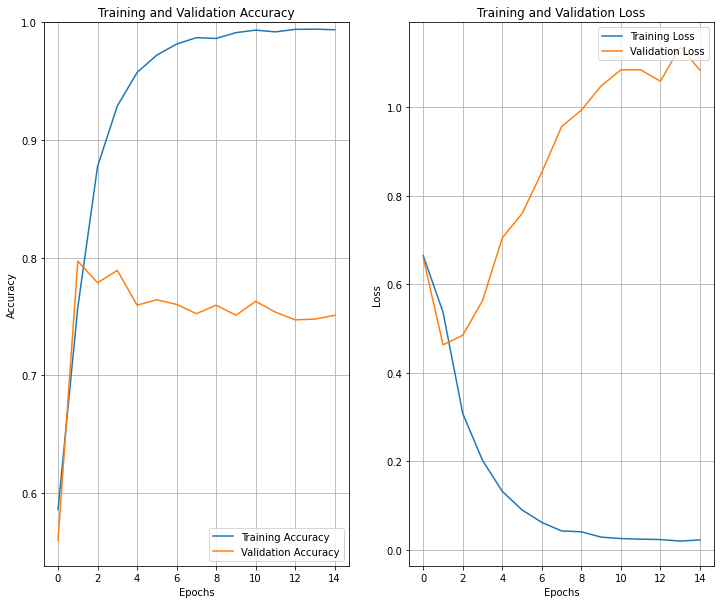

In [28]:
#Plotting Accuracy and Loss of Training and Validation set

def plot_history(history, metric, val_metric,EPOCHS):
    acc = history.history[metric]
    val_acc = history.history[val_metric]
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(EPOCHS)

    fig=plt.figure(figsize=(12, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()),1])
    plt.grid(True)
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title('Training and Validation Loss')
    plt.show()


plot_history(history1,'accuracy','val_accuracy',EPOCHS)

In [29]:
#predict using the trained Model-1

pred1 = model1.predict_classes(validation_padded)


 Model-1 Precision_score
 [0.77427491 0.7260274 ]

 Model-1 Recall_score
 [0.75429975 0.74753173]

 Model-1 Accuracy_score
 0.7511490479317138

 Model-1 F1_score
 [0.76415681 0.73662265]


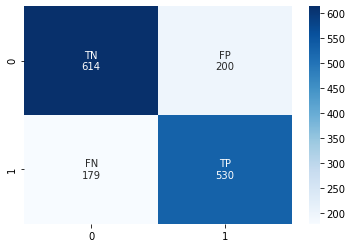

In [30]:
#Measuring the performance using various metrics: Precision, Recall, F1 score, Overall Accuracy

cnf_matrix = confusion_matrix(valid_labels,pred1)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

precision_scoreM1=precision_score(valid_labels,pred1, average=None)
print("\n Model-1 Precision_score\n", precision_scoreM1)

recall_scoreM1=recall_score(valid_labels,pred1, average=None)
print("\n Model-1 Recall_score\n",recall_scoreM1)

accuracy_scoreM1=accuracy_score(valid_labels,pred1)
print("\n Model-1 Accuracy_score\n",accuracy_scoreM1)

f1_scoreM1=f1_score(valid_labels,pred1, average=None)
print("\n Model-1 F1_score\n",f1_scoreM1)

# 6. Model-2

Using a pre-trained model

In [31]:
embedding_dict={}
with open('../input/glove6b100dtxt/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [32]:
words_na = []
embedding_matrix = np.zeros((num_words,100))
word_index = tokenizer.word_index
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    emb_vec=embedding_dict.get(word)
    
    if emb_vec is None:
        
        
        words_na.append(word)
    
    elif emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 18852/18852 [00:00<00:00, 305154.48it/s]


In [33]:
print("Out of vocabulory words:",len(words_na))

Out of vocabulory words: 7259


In [34]:
model2 = tf.keras.Sequential([
tf.keras.layers.Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),trainable=False),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy']) 

In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1885300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,978,101
Trainable params: 92,801
Non-trainable params: 1,885,300
_________________________________________________________________


In [36]:
#train Model-2

history21 = model2.fit(training_padded, y_train,epochs=EPOCHS,batch_size=12, validation_data=(validation_padded, valid_labels), verbose=2)

Epoch 1/15
508/508 - 6s - loss: 0.5560 - accuracy: 0.7386 - val_loss: 0.4462 - val_accuracy: 0.8024
Epoch 2/15
508/508 - 5s - loss: 0.4461 - accuracy: 0.8025 - val_loss: 0.4229 - val_accuracy: 0.8148
Epoch 3/15
508/508 - 5s - loss: 0.4248 - accuracy: 0.8123 - val_loss: 0.4167 - val_accuracy: 0.8207
Epoch 4/15
508/508 - 5s - loss: 0.4140 - accuracy: 0.8195 - val_loss: 0.4148 - val_accuracy: 0.8181
Epoch 5/15
508/508 - 5s - loss: 0.4030 - accuracy: 0.8269 - val_loss: 0.4331 - val_accuracy: 0.8135
Epoch 6/15
508/508 - 5s - loss: 0.3956 - accuracy: 0.8305 - val_loss: 0.4124 - val_accuracy: 0.8207
Epoch 7/15
508/508 - 5s - loss: 0.3889 - accuracy: 0.8304 - val_loss: 0.4120 - val_accuracy: 0.8188
Epoch 8/15
508/508 - 5s - loss: 0.3807 - accuracy: 0.8351 - val_loss: 0.4199 - val_accuracy: 0.8162
Epoch 9/15
508/508 - 5s - loss: 0.3721 - accuracy: 0.8386 - val_loss: 0.4258 - val_accuracy: 0.8116
Epoch 10/15
508/508 - 5s - loss: 0.3648 - accuracy: 0.8443 - val_loss: 0.4213 - val_accuracy: 0.8194

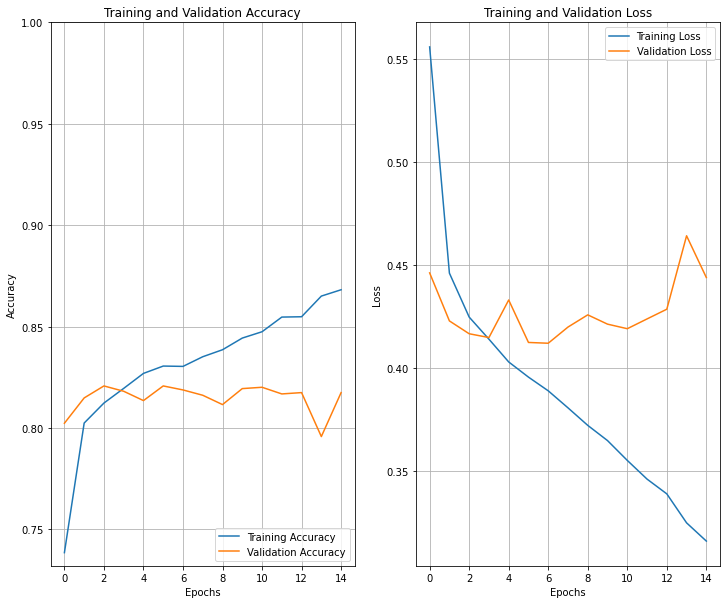

In [37]:
#Plot the results of Model-2

plot_history(history21,'accuracy','val_accuracy',EPOCHS)

In [38]:
#Predict using the trained Model-2

pred21 = model2.predict_classes(validation_padded)


 Model-21 Precision_score
 [0.80316742 0.8372457 ]

 Model-21 Recall_score
 [0.87223587 0.75458392]

 Model-21 Accuracy_score
 0.8174655285620486

 Model-21 F1_score
 [0.83627797 0.79376855]


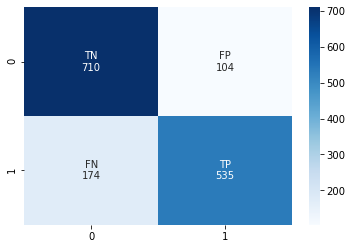

In [39]:
#Measuring the performance using various metrics: Precision, Recall, F1 score, Overall Accuracy

cnf_matrix = confusion_matrix(valid_labels,pred21)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');


precision_scoreM2=precision_score(valid_labels,pred21, average=None)
print("\n Model-21 Precision_score\n", precision_scoreM2)

recall_scoreM2=recall_score(valid_labels,pred21, average=None)
print("\n Model-21 Recall_score\n",recall_scoreM2)

accuracy_scoreM2=accuracy_score(valid_labels,pred21)
print("\n Model-21 Accuracy_score\n",accuracy_scoreM2)

f1_scoreM2=f1_score(valid_labels,pred21, average=None)
print("\n Model-21 F1_score\n",f1_scoreM2)

Using a Regularization technique called "Early Stopping"

In [40]:
#configure the early-stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0,restore_best_weights=True, mode='auto')

#train the Model-2 again but this time with early-stop
history22 = model2.fit(training_padded, y_train,epochs=EPOCHS,batch_size=12, validation_data=(validation_padded, valid_labels), verbose=2,callbacks=[earlystop])

Epoch 1/15
508/508 - 5s - loss: 0.3059 - accuracy: 0.8770 - val_loss: 0.4522 - val_accuracy: 0.8168
Epoch 2/15
508/508 - 5s - loss: 0.2946 - accuracy: 0.8803 - val_loss: 0.4587 - val_accuracy: 0.8109
Epoch 3/15
508/508 - 5s - loss: 0.2832 - accuracy: 0.8859 - val_loss: 0.4879 - val_accuracy: 0.8083
Epoch 4/15
508/508 - 5s - loss: 0.2744 - accuracy: 0.8920 - val_loss: 0.4717 - val_accuracy: 0.8168
Epoch 5/15
508/508 - 5s - loss: 0.2620 - accuracy: 0.8977 - val_loss: 0.4889 - val_accuracy: 0.8089
Epoch 6/15
508/508 - 6s - loss: 0.2527 - accuracy: 0.8995 - val_loss: 0.4905 - val_accuracy: 0.8122


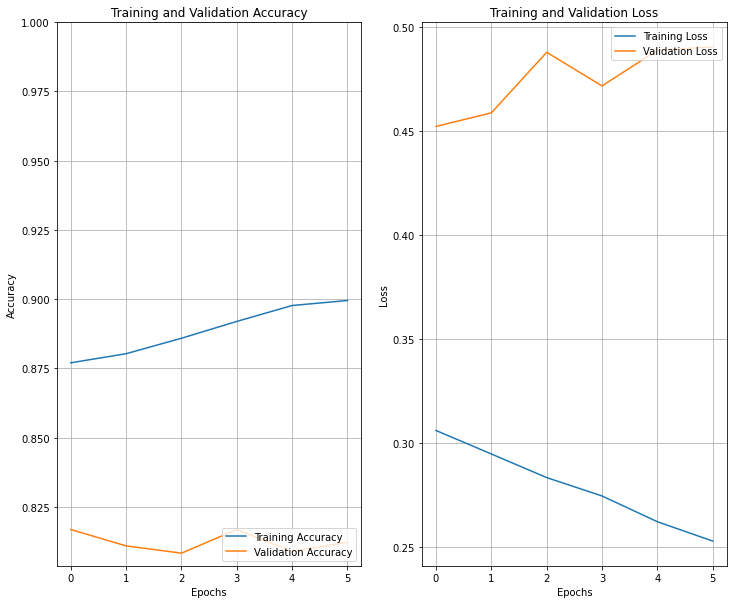

In [42]:
#Plot results of early-stop
plot_history(history22,'accuracy','val_accuracy',6)

In [43]:
#Predict
pred22 = model2.predict_classes(validation_padded)


 Model-22 Precision_score
 [0.79044517 0.85714286]

 Model-22 Recall_score
 [0.89434889 0.72778561]

 Model-22 Accuracy_score
 0.8168089297439265

 Model-22 F1_score
 [0.83919308 0.78718535]


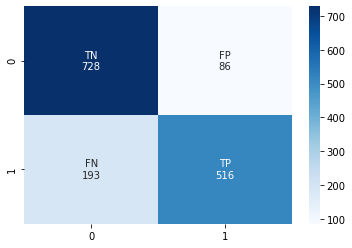

In [44]:
#Measuring the performance using various metrics: Precision, Recall, F1 score, Overall Accuracy

cnf_matrix = confusion_matrix(valid_labels,pred22)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');


precision_scoreM22=precision_score(valid_labels,pred22, average=None)
print("\n Model-22 Precision_score\n", precision_scoreM22)

recall_scoreM22=recall_score(valid_labels,pred22, average=None)
print("\n Model-22 Recall_score\n",recall_scoreM22)

accuracy_scoreM22=accuracy_score(valid_labels,pred22)
print("\n Model-22 Accuracy_score\n",accuracy_scoreM22)

f1_scoreM22=f1_score(valid_labels,pred22, average=None)
print("\n Model-22 F1_score\n",f1_scoreM22)

In [45]:
#predict the test data

test_pred = model2.predict(test_padded) 

In [46]:
sub['target'] = (test_pred > 0.5).astype(int)

In [47]:
sub.to_csv("submission.csv", index=False, header=True)